# Introduction
This notebook was the coding part of my bachelor thesis, titled **The Effect of Fluorination on the Structure and Dynamics of the Hexapeptide VG(Abu)APG**. In this project, I tried to isolate the effect of fluorinated Abu (mono-, di- and trifluorination) by studying it on a small hexapeptide, which is derived from VGLAPG to study the structure and its kinetics.

The simulation itself was carried on GROMACS 2019.1 using the topology created in PyMol. Here we only analyze their structure by analyzing their Ramachandran plot, side chain torsion angle profiles ($\chi_1$), end-to-end distance and the formed intramolecular hydrogen bonds.

In this published project, I only use a shorter trajectory length (100 ns instead of 500 ns) due to the size of the file. In the production run in GROMACS, each hexapeptides were simulated for a total time of 100 ns with 2 fs timestep and the trajectories were saved every picosecond, so in the end we have 100.000 data points.

A visualization of the hexapeptide:

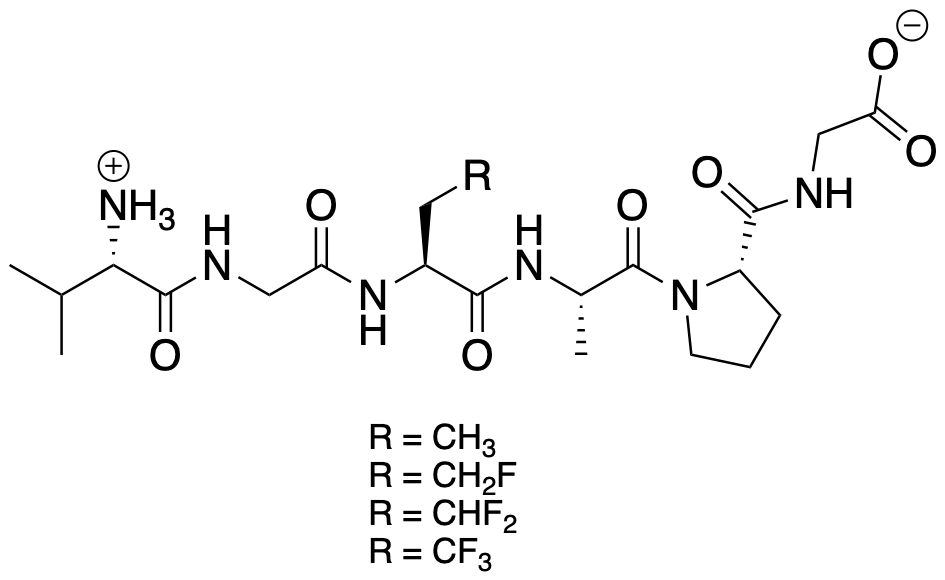

In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md
%matplotlib inline
import pandas as pd
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import warnings
warnings.filterwarnings("ignore")

In [3]:
# publication-ready graph settings

plt.rcParams['figure.figsize'] = [7, 5]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')


# load trajectories

After generating the topology file in PyMol, a series of 100 ns trajectory from 4 different hexapeptide mutants were generated in Gromacs 2019.1. The trajectories are then being loaded using `mdtraj` package.

In [4]:
traj_abu = md.load_xtc("traj_abu_100.xtc", top ="md_abu.pdb")
traj_mfe = md.load_xtc("traj_mfe_100.xtc", top ="md_mfe.pdb")
traj_dfe = md.load_xtc("traj_dfe_100.xtc", top ="md_dfe.pdb")
traj_tfe = md.load_xtc("traj_tfe_100.xtc", top ="md_tfe.pdb")

In [5]:
traj_abu

<mdtraj.Trajectory with 100000 frames, 70 atoms, 6 residues, and unitcells at 0x7f98a8e05160>

## Sliced trajectory

to build its mean, we slice the trajectory into 5 small portions with the same length of 20.000 ns and build the average over them.

In [6]:
for i in ["abu", "mfe", "dfe", "tfe"]:
    globals()['%s' % i] = []
    for j in range(1,6):
        globals()['%s_%s' % (i, j)] = globals()['traj_%s' % (i)][20000*j-20000:20000*j]
        globals()['%s' % i].append(globals()['%s_%s' % (i, j)])
        

In [7]:
abu_1

<mdtraj.Trajectory with 20000 frames, 70 atoms, 6 residues, and unitcells at 0x7f98a8e1eaf0>

In [8]:
#### FITTED TRAJECTORY ####

for i in ["abu", "mfe", "dfe", "tfe"]:
    globals()['ft_%s' % i] = []
    for j in range(1,6):
        globals()['ft_%s_%s' % (i, j)] = globals()['%s_%s' % (i, j)].superpose(
            globals()['%s_%s' % (i, j)], 
            frame = 0, 
            atom_indices = globals()['%s_%s' % (i, j)].topology.select("protein and backbone"), 
            ref_atom_indices = None, 
            parallel = True).center_coordinates()
        globals()['ft_%s' % i].append(globals()['ft_%s_%s' % (i, j)])

In [9]:
ft_abu_1

<mdtraj.Trajectory with 20000 frames, 70 atoms, 6 residues, and unitcells at 0x7f98a8e1eaf0>

In [10]:
#### SIDECHAIN AND BACKBONE ####

for i in ["abu", "mfe", "dfe", "tfe"]:
    for j in range(1,6):
        globals()['%s_%s_sidechain' % (i, j)] = globals()['%s_%s' % (i, j)].topology.select("sidechain")
        globals()['%s_%s_backbone' % (i, j)] = globals()['%s_%s' % (i, j)].topology.select("backbone")

In [11]:
abu_1_sidechain

array([19, 21, 22, 39, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 59])

## Root-mean-square deviation of atomic positions (RMSD)

Root-mean-square deviation of atomic positions (RMSD) is a measure of the average distance between the atoms (usually the backbone atoms) of superimposed proteins.

In [47]:
# total rmsd
rmsd_abu = md.rmsd(traj_abu, traj_abu, frame=0, atom_indices = None)
rmsd_mfe = md.rmsd(traj_mfe, traj_mfe, frame=0, atom_indices = None)
rmsd_dfe = md.rmsd(traj_dfe, traj_dfe, frame=0, atom_indices = None)
rmsd_tfe = md.rmsd(traj_tfe, traj_tfe, frame=0, atom_indices = None)

In [15]:
len(t_rmsd)

100000

In [50]:
import seaborn as sns

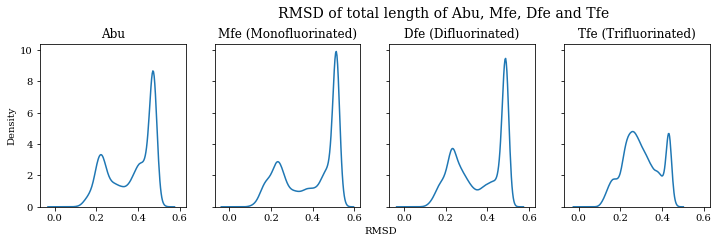

In [255]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)

#sns.histplot(rmsd_abu, kde=True, stat='density', ax = ax[0])
#sns.histplot(rmsd_mfe, kde=True, stat='density', ax = ax[1])
#sns.histplot(rmsd_dfe, kde=True, stat='density', ax = ax[2])
#sns.histplot(rmsd_tfe, kde=True, stat='density', ax = ax[3])

sns.kdeplot(rmsd_abu, ax = ax[0])
sns.kdeplot(rmsd_mfe, ax = ax[1])
sns.kdeplot(rmsd_dfe, ax = ax[2])
sns.kdeplot(rmsd_tfe, ax = ax[3])

ax[0].set_title("Abu")
ax[1].set_title("Mfe (Monofluorinated)")
ax[2].set_title("Dfe (Difluorinated)")
ax[3].set_title("Tfe (Trifluorinated)")

fig.text(0.4,1,"RMSD of total length of Abu, Mfe, Dfe and Tfe", fontsize=14)

fig.text(0.5,0,"RMSD")

plt.show()


# Ramachandran
## Of the total length 100 ns
still using unsliced trajectory

In [74]:
aa = ["val", "gly", "exg", "ala", "pro"]

In [75]:
for i in name:
    globals()['phi_%s' % i] = md.compute_phi(globals()['traj_%s' % i], periodic = True)
    globals()['psi_%s' % i] = md.compute_psi(globals()['traj_%s' % i], periodic = True)
    

In [76]:
phi_abu

(array([[16, 18, 20, 23],
        [23, 25, 27, 36],
        [36, 38, 40, 46],
        [46, 48, 58, 60],
        [60, 62, 64, 67]]),
 array([[ 1.0448806 , -1.9086252 , -0.8275995 , -0.8692439 ,  2.9016583 ],
        [ 1.1646607 , -2.3804555 , -1.2949417 , -1.070877  , -2.7869244 ],
        [ 1.2267789 , -1.8583063 , -1.5769606 , -1.0732813 , -2.804718  ],
        ...,
        [-2.9417415 , -1.2187061 , -1.4051429 , -0.99279916,  2.4657102 ],
        [ 2.9327266 , -1.134866  , -1.2873248 , -1.4100044 ,  2.2020323 ],
        [-3.1046345 , -1.0785531 , -1.5663179 , -1.4166149 ,  2.388497  ]],
       dtype=float32))

In [77]:
# coordinate of phi and psi
# taking abu as the input because in all 4 they are the same

r_phi = phi_abu[0:1]
r_psi = psi_abu[0:1]

In [227]:
r_phi

(array([[16, 18, 20, 23],
        [23, 25, 27, 36],
        [36, 38, 40, 46],
        [46, 48, 58, 60],
        [60, 62, 64, 67]]),)

In [78]:
#### PHI AND PSI FOR EACH AMINO ACID ####

for i in ["phi", "psi"]:
    for j in range(len(aa)):
        # phi_val = np.array(r_phi)[:,0]
        globals()['%s_%s' % (i, aa[j])] = np.array(globals()['r_%s' % i])[:,j]

In [79]:
#### RAD2DEG ####

for i in range(len(name)):
    for j in range(len(aa)):
        globals()['angles_%s_%s' % (name[i], aa[j])] = np.rad2deg(
            md.compute_dihedrals(
                globals()['traj_%s' % name[i]],
                (globals()['phi_%s' % aa[j]][0], globals()['psi_%s' % aa[j]][0])))

In [80]:
angles_mfe_exg

array([[ -59.233215,  171.00758 ],
       [ -58.022312,  160.36806 ],
       [ -60.872246,  158.23444 ],
       ...,
       [-126.11607 ,   21.338787],
       [-102.78993 ,   13.239498],
       [-101.74979 ,   -4.21031 ]], dtype=float32)

In [81]:
for i in name:
    for j in aa:
        globals()['hist_%s_phi' % i], globals()['x_%s_phi' % i] = np.histogram(globals()['angles_%s_%s' % (i,j)], bins = 12, density = True)
        globals()['hist_%s_psi' % i], globals()['x_%s_psi' % i] = np.histogram(globals()['angles_%s_%s' % (i,j)], bins = 12, density = True)

In [82]:
hist_abu_psi

array([2.39250974e-03, 7.91002816e-04, 1.03617088e-03, 1.64033938e-03,
       4.66668477e-04, 4.57668442e-04, 9.71670435e-05, 9.90337174e-04,
       4.77551761e-03, 2.52567694e-03, 7.05719179e-03, 1.11032118e-02])

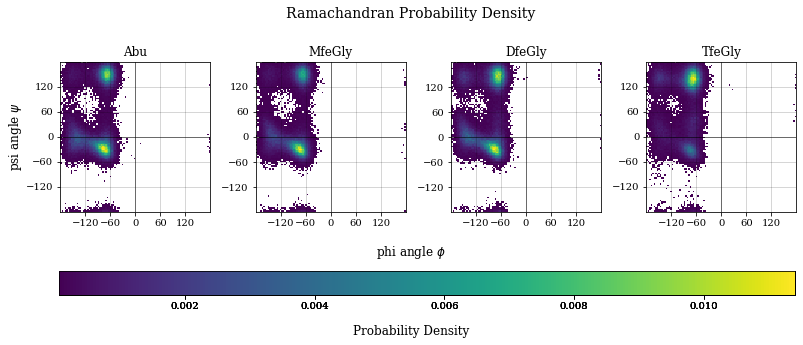

In [85]:
figure = plt.figure(figsize=(11,11))
#ax = plt.subplots()

for i in range(1,5):
    globals()['ax%s' % i] = figure.add_subplot(140+i)
    globals()['ax%s' % i].set_box_aspect(1)
    globals()['ax%s' % i].axhline(y=0, color='k', lw=0.5)
    globals()['ax%s' % i].axvline(x=0, color='k', lw=0.5)
    plt.xticks(ticks = (-180, -120, -60, 0, 60, 120, 180))
    plt.yticks(ticks = (-180, -120, -60, 0, 60, 120, 180))
    plt.xlim(-180,180)
    plt.ylim(-180,180) 
    cax = figure.add_axes([0.055, 0.3, 0.93, 0.03])
    cmap = plt.get_cmap("viridis")
    norm = mpl.colors.Normalize(vmin=hist_tfe_psi.min(), vmax=hist_tfe_psi.max())
    sm =  ScalarMappable(norm = norm, cmap=cmap)
    sm.set_array([])
    cbar = figure.colorbar(sm, cax=cax, orientation = 'horizontal')
    #cbar.ax.set_xlabel('Probability Density')
    
ax1.hist2d(angles_abu_exg[:, 0], angles_abu_exg[:, 1], bins=(100, 100), cmin=1)
ax2.hist2d(angles_mfe_exg[:, 0], angles_mfe_exg[:, 1], bins=(100, 100), cmin=1)
ax3.hist2d(angles_dfe_exg[:, 0], angles_dfe_exg[:, 1], bins=(100, 100), cmin=1)
ax4.hist2d(angles_tfe_exg[:, 0], angles_tfe_exg[:, 1], bins=(100, 100), cmin=1)

ax1.set_title("Abu")
ax2.set_title("MfeGly")
ax3.set_title("DfeGly")
ax4.set_title("TfeGly")
    
for i in range(1,5):
    globals()['ax%s' % i].grid(b=True, color='black', alpha=0.2)
    
figure.text(0.5, 0.65, "Ramachandran Probability Density", ha='center', fontsize=14)
figure.text(0.5, 0.35, "phi angle $\phi$", ha='center', fontsize = 12)
figure.text(-0.01, 0.5, 'psi angle $\psi$', va='center', rotation='vertical', fontsize = 12)
figure.text(0.5, 0.25, "Probability Density", ha='center', fontsize=12)


plt.tight_layout()
plt.show()
#figure.savefig("pr/rama_pd.jpeg", dpi=200, bbox_inches='tight')


In the figure above, it is shown that for each hexapeptide, they do exist as right-handed $\alpha$-Helix and $\beta$ sheets. There is a trend that the more fluorinated a hexapeptide is, the less area they visit in the Ramachandran plot. This can be interpreted as lesser flexibility in the hexapeptides, especially for TfeGly.

In this shorter simulation, none of them visit the left-handed $\beta$ sheets. This may indicate either they do not visit the $\beta$ sheets region at all, or we need a longer simulation length.

# side chain torsion angle profiles $\chi_1$

In [86]:
for i in name:
    globals()['chi1_%s' %i] = md.compute_chi1(globals()['traj_%s' %i], periodic = True)

In [87]:
c_chi1 = chi1_abu[0:1]
c_chi1

(array([[ 0,  4,  6,  8],
        [25, 27, 29, 32],
        [48, 58, 55, 52]]),)

In [88]:
np.array(c_chi1)[:,0]

array([[0, 4, 6, 8]])

In [89]:
#### AA WITH CHI1 IN THE CHAIN: VAL, EXG, PRO ###

chi1_chain = ["val", "exg", "pro"]

for i in range(len(chi1_chain)):
    globals()['angle_%s' % chi1_chain[i]] = np.array(c_chi1)[:,i]

In [90]:
angle_val

array([[0, 4, 6, 8]])

In [91]:
c_chi1

(array([[ 0,  4,  6,  8],
        [25, 27, 29, 32],
        [48, 58, 55, 52]]),)

### for whole series

In [92]:
for i in name:
    for j in chi1_chain:
        globals()['dihedral_%s_%s' % (i, j)] = np.rad2deg(
            md.compute_dihedrals(globals()['traj_%s' % i], globals()['angle_%s' % j]))

In [93]:
dihedral_abu_exg

array([[ 170.14764 ],
       [-171.71428 ],
       [-170.7096  ],
       ...,
       [ -67.203964],
       [ -65.35727 ],
       [ -62.26182 ]], dtype=float32)

### for sliced with length = 20000 ns each

In [94]:
for i in name:
    for j in chi1_chain:
        for k in range(1,6):
            globals()['dihedral_%s_%s_%s' % (i, j, k)] = np.rad2deg(
                md.compute_dihedrals(globals()['%s_%s' % (i,k)], globals()['angle_%s' % j]))

In [95]:
dihedral_abu_exg_1

array([[ 170.14764],
       [-171.71419],
       [-170.70963],
       ...,
       [  82.92079],
       [  80.87554],
       [  62.03158]], dtype=float32)

### visualization

In [96]:
bins_ = 100

for i in name:
    for j in chi1_chain:
        globals()['h_chi1_%s_%s' % (i, j)], globals()['e_chi1_%s_%s' % (i, j)] = np.histogram(
            globals()['dihedral_%s_%s' % (i,j)][:,0], bins = bins_, density = True)

In [97]:
e_chi1 = [globals()['e_chi1_%s_%s' % (i,j)] for i in name for j in chi1_chain]

In [98]:
x_chi1_abu_val = (e_chi1_abu_val[1:] + e_chi1_abu_val[:-1]) / 2
x_chi1_mfe_val = (e_chi1_mfe_val[1:] + e_chi1_mfe_val[:-1]) / 2
x_chi1_dfe_val = (e_chi1_dfe_val[1:] + e_chi1_dfe_val[:-1]) / 2
x_chi1_tfe_val = (e_chi1_tfe_val[1:] + e_chi1_tfe_val[:-1]) / 2

x_chi1_abu_exg = (e_chi1_abu_exg[1:] + e_chi1_abu_exg[:-1]) / 2
x_chi1_mfe_exg = (e_chi1_mfe_exg[1:] + e_chi1_mfe_exg[:-1]) / 2
x_chi1_dfe_exg = (e_chi1_dfe_exg[1:] + e_chi1_dfe_exg[:-1]) / 2
x_chi1_tfe_exg = (e_chi1_tfe_exg[1:] + e_chi1_tfe_exg[:-1]) / 2

x_chi1_abu_pro = (e_chi1_abu_pro[1:] + e_chi1_abu_pro[:-1]) / 2
x_chi1_mfe_pro = (e_chi1_mfe_pro[1:] + e_chi1_mfe_pro[:-1]) / 2
x_chi1_dfe_pro = (e_chi1_dfe_pro[1:] + e_chi1_dfe_pro[:-1]) / 2
x_chi1_tfe_pro = (e_chi1_tfe_pro[1:] + e_chi1_tfe_pro[:-1]) / 2

In [99]:
len(x_chi1_abu_pro)

100

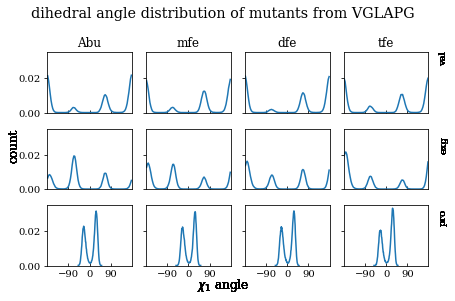

In [100]:
fig, axs = plt.subplots(3,4, sharex = True, sharey = True)
fig.suptitle("dihedral angle distribution of mutants from VGLAPG", fontsize = "x-large")

#abu
axs[0,0].set_title("Abu")
axs[0,0].plot(x_chi1_abu_val, h_chi1_abu_val)
axs[1,0].plot(x_chi1_abu_exg, h_chi1_abu_exg)
axs[2,0].plot(x_chi1_abu_pro, h_chi1_abu_pro)

#mfe
axs[0,1].set_title("mfe")
axs[0,1].plot(x_chi1_mfe_val, h_chi1_mfe_val)
axs[1,1].plot(x_chi1_mfe_exg, h_chi1_mfe_exg)
axs[2,1].plot(x_chi1_mfe_pro, h_chi1_mfe_pro)

#dfe
axs[0,2].set_title("dfe")
axs[0,2].plot(x_chi1_dfe_val, h_chi1_dfe_val)
axs[1,2].plot(x_chi1_dfe_exg, h_chi1_dfe_exg)
axs[2,2].plot(x_chi1_dfe_pro, h_chi1_dfe_pro)

#tfe
axs[0,3].set_title("tfe")
axs[0,3].plot(x_chi1_tfe_val, h_chi1_tfe_val)
axs[1,3].plot(x_chi1_tfe_exg, h_chi1_tfe_exg)
axs[2,3].plot(x_chi1_tfe_pro, h_chi1_tfe_pro)
#general formatting
for ax in axs.flat:
    ax.label_outer()
    fig.text(0.5, 0, "$\chi_1$ angle", ha = "center", fontsize = 12)
    fig.text(0, 0.5, "count", va = "center", rotation ="vertical", fontsize = 12)
    fig.text(1, 0.25, "pro", va = "center", rotation ="vertical")
    fig.text(1, 0.5, "exg", va = "center", rotation ="vertical")
    fig.text(1, 0.8, "val", va = "center", rotation ="vertical")
    ax.tick_params(axis="x", direction="in")
    ax.set(**{
        "xticks": (-90, 0, 90),
        "xlim": (-180, 180),
        "ylim": (0)
    })


plt.tight_layout()
plt.show()
#fig.savefig("dihedral angle distribution-np.svg")

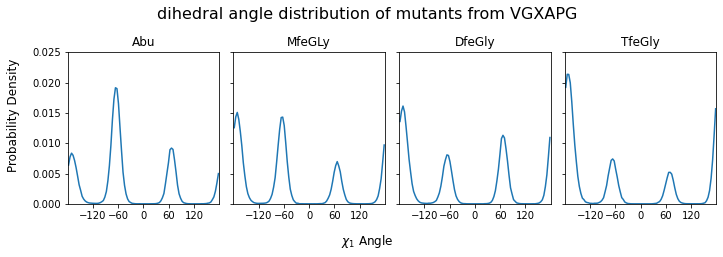

In [107]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (10,10))
fig.suptitle('dihedral angle distribution of mutants from VGXAPG',
             fontsize = 16,
            y = .65)

#abu
ax1.set_title("Abu")
ax1.plot(x_chi1_abu_exg, h_chi1_abu_exg)
ax1.set_ylabel(" ")

#mfe
ax2.set_title("MfeGLy")
ax2.plot(x_chi1_mfe_exg, h_chi1_mfe_exg)

#dfe
ax3.set_title("DfeGly")
ax3.plot(x_chi1_dfe_exg, h_chi1_dfe_exg)

#tfe
ax4.set_title("TfeGly")
ax4.plot(x_chi1_tfe_exg, h_chi1_tfe_exg)

#general formatting
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax4.set_box_aspect(1)

fig.text(0.5, 0.32, "$\chi_1$ Angle", ha='center', fontsize = 12)
fig.text(0, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 12)

plt.ylim(0, 0.025)
plt.xlim(-180,180)
plt.xticks([-120, -60, 0, 60, 120])
plt.tight_layout()
plt.show()
#fig.savefig("graph/500_chi1.svg", bbox_inches='tight')

### chi1 mean & error

In [101]:
chi1_chain

['val', 'exg', 'pro']

In [102]:
dihedral_abu_val_2

array([[-171.21806],
       [ 174.87457],
       [ 165.96779],
       ...,
       [ 163.86626],
       [ 164.72475],
       [ 168.14839]], dtype=float32)

In [103]:
#### ------------------------------- ####
#### HISTOGRAM FOR SLICED TRAJECTORY ####
#### ------------------------------- ####
for i in name:
    for j in chi1_chain:
        for k in range(1,6):
            globals()['h_chi1_%s_%s_%s' % (i, j, k)], globals()['e_chi1_%s_%s_%s' % (i,j,k)] = np.histogram(globals()['dihedral_%s_%s_%s' % (i,j,k)][:,0], bins = bins_, density = True)

In [104]:
#### ------------------------------- ####
#### AXIS FOR SLICED TRAJECTORY      ####
#### ------------------------------- ####

for i in name:
    for j in chi1_chain:
        for k in range(1,6):
            globals()['x_chi1_%s_%s_%s' % (i, j, k)] = (globals()['e_chi1_%s_%s_%s' % (i,j,k)][1:] + globals()['e_chi1_%s_%s_%s' % (i,j,k)][:-1]) /2
            
            

In [105]:
len(x_chi1_abu_val_1)

100

In [106]:
#### ------------------------------- ####
#### MEAN FOR SLICED TRAJECTORY      ####
#### ------------------------------- ####

In [107]:
#### ------------------------------- ####
#### ARRAY FOR SLICED TRAJECTORY     ####
#### ------------------------------- ####

for i in name:
    for j in chi1_chain:
        globals()['array_%s_%s' % (i,j)] = []

for i in name:
    for j in chi1_chain:
        for k in range(1,6):
            globals()['array_%s_%s' % (i,j)].append(np.array(globals()['h_chi1_%s_%s_%s' % (i,j,k)]))

In [123]:
#### ------------------------------- ####
#### MEAN CHI1                       ####
#### ------------------------------- ####

for i in name:
    for j in chi1_chain:
        globals()['mean_chi1_%s_%s' % (i,j)] = np.mean(globals()['array_%s_%s' % (i,j)], axis = 0)
    
#### ------------------------------- ####
#### ERROR CHI1                      ####
#### ------------------------------- ####

for i in name:
    for j in chi1_chain:
        globals()['error_chi1_%s_%s' % (i,j)] = np.std(globals()['array_%s_%s' % (i,j)], axis = 0)

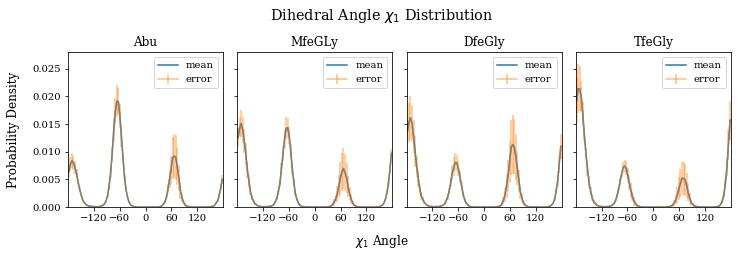

In [127]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (10,10))
fig.suptitle("Dihedral Angle $\chi_1$ Distribution", fontsize = "x-large", y = .65)

ax1.plot(x_chi1_abu_exg, h_chi1_abu_exg, label = "mean")
ax2.plot(x_chi1_mfe_exg, h_chi1_mfe_exg, label = "mean")
ax3.plot(x_chi1_dfe_exg, h_chi1_dfe_exg, label = "mean")
ax4.plot(x_chi1_tfe_exg, h_chi1_tfe_exg, label = "mean")

ax1.errorbar(x_chi1_abu_exg, h_chi1_abu_exg, yerr = error_chi1_abu_exg, label = "error", alpha = 0.5)
ax2.errorbar(x_chi1_mfe_exg, h_chi1_mfe_exg, yerr = error_chi1_mfe_exg, label = "error", alpha = 0.5)
ax3.errorbar(x_chi1_dfe_exg, h_chi1_dfe_exg, yerr = error_chi1_dfe_exg, label = "error", alpha = 0.5)
ax4.errorbar(x_chi1_tfe_exg, h_chi1_tfe_exg, yerr = error_chi1_tfe_exg, label = "error", alpha = 0.5)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_title("Abu")
ax2.set_title("MfeGLy")
ax3.set_title("DfeGly")
ax4.set_title("TfeGly")

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax4.set_box_aspect(1)


fig.text(0.5, 0.32, "$\chi_1$ Angle", ha='center', fontsize = 12)
fig.text(-0.02, 0.48, 'Probability Density', va='center', rotation='vertical', fontsize = 12)

plt.ylim(0, 0.028)
plt.xlim(-180,180)
plt.xticks([-120, -60, 0, 60, 120])
plt.tight_layout()
plt.show()
#fig.savefig("graph/500_chi1_mean_error.png", bbox_inches='tight')

**INTERPRETATION**

Plotting the distribution of the side chain torsion angle $\chi_1$ can also be used to visualize the flexibility of the hexapeptides. Plotted as histogram and weighing the probability density, the side chain torsion angle $\chi_1$ profiles reveal that there is an increasing trend of the trans conformation ($+/-$180°), which happens simultaneously with the decrease of the gauche(+) conformation (-60°). This can be interpreted that the more substituted a hexapeptide with fluorine is, the higher is the tendency to be in a trans conformation due to the steric hinderance with other atoms in the molecule. The gauche(-) conformation (+60°), on the other hand, seems to be stagnant as the more fluorinated a hexapeptide is, and there is no meaningful difference in the result.

We can also see that the errors are relatively large—this is also an indication that the sample size (length of the trajectory) is too small, hence we need a longer simulation.

# end-to-end distance

begin: N-capping @ 0

end: C-capping @ 67

**SLICED!**

In [41]:
trajectory_abu_500.topology.to_dataframe()

(    serial name element  resSeq resName  chainID segmentID
 0        1    N       N       2    NVAL        0          
 1        2   H1       H       2    NVAL        0          
 2        3   H2       H       2    NVAL        0          
 3        4   H3       H       2    NVAL        0          
 4        5   CA       C       2    NVAL        0          
 ..     ...  ...     ...     ...     ...      ...       ...
 65      66  HA1       H       7    CGLY        0          
 66      67  HA2       H       7    CGLY        0          
 67      68    C       C       7    CGLY        0          
 68      69  OC1       O       7    CGLY        0          
 69      70  OC2       O       7    CGLY        0          
 
 [70 rows x 7 columns],
 array([[16., 18.,  0.,  0.],
        [20., 23.,  0.,  0.],
        [23., 24.,  0.,  0.],
        [20., 22.,  0.,  0.],
        [20., 21.,  0.,  0.],
        [18., 20.,  0.,  0.],
        [18., 19.,  0.,  0.],
        [36., 38.,  0.,  0.],
        [40., 

In [129]:
md.compute_distances(abu_1, [[0,67]], periodic=True)

array([[1.5657041],
       [1.5638269],
       [1.5494657],
       ...,
       [1.1033953],
       [1.1258743],
       [1.1789696]], dtype=float32)

In [131]:
for i in name:
    for j in range(1,6):
        globals()['cd_%s_%s' % (i,j)] = md.compute_distances(globals()['%s_%s' % (i,j)], [[0,67]], periodic=True)

In [148]:
cd_abu = md.compute_distances(traj_abu, [[0,67]], periodic=True)
cd_mfe = md.compute_distances(traj_mfe, [[0,67]], periodic=True)
cd_dfe = md.compute_distances(traj_dfe, [[0,67]], periodic=True)
cd_tfe = md.compute_distances(traj_tfe, [[0,67]], periodic=True)


In [149]:
cd_abu

array([[1.5657041 ],
       [1.563827  ],
       [1.549466  ],
       ...,
       [0.74148905],
       [0.76861167],
       [0.77236396]], dtype=float32)

(array([14747.,  3008.,  2344.,  2142.,  3740.,  8012., 14648., 22375.,
        26116.,  2868.]),
 array([0.27638018, 0.4494231 , 0.622466  , 0.795509  , 0.9685519 ,
        1.1415949 , 1.3146378 , 1.4876807 , 1.6607236 , 1.8337666 ,
        2.0068095 ], dtype=float32),
 <BarContainer object of 10 artists>)

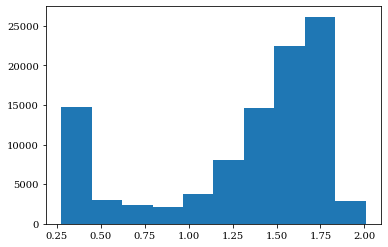

In [151]:
plt.hist(cd_tfe)

In [158]:
cd_abu.shape

(100000, 1)

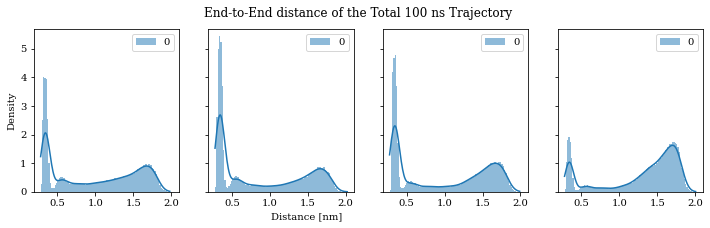

In [181]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)

plt.suptitle("End-to-End distance of the Total 100 ns Trajectory")

sns.histplot(cd_abu, stat='density', bins=100, kde=True, linewidth=0, ax=ax[0])
sns.histplot(cd_mfe, stat='density', bins=100, kde=True, linewidth=0, ax=ax[1])
sns.histplot(cd_dfe, stat='density', bins=100, kde=True, linewidth=0, ax=ax[2])
sns.histplot(cd_tfe, stat='density', bins=100, kde=True, linewidth=0, ax=ax[3])

fig.text(0.4,0, "Distance [nm]")

plt.show()

## distribution

In [19]:
#h_abu, xedges_abu = np.histogram(backbone_rmsd_abu_500, bins=60, density=True,)

#mids = (xedges_abu[1:] + xedges_abu[:-1]) / 2
#mids_mfe = (xedges_mfe[1:] + xedges_mfe[:-1]) / 2
#mids_dfe = (xedges_dfe[1:] + xedges_dfe[:-1]) / 2
#mids_tfe = (xedges_tfe[1:] + xedges_tfe[:-1]) / 2


In [189]:
n = 100

for i in name:
    for j in range(1,6):
        globals()['h_ee_%s_%s' % (i,j)], globals()['e_ee_%s_%s' % (i,j)] = np.histogram(
            globals()['cd_%s_%s' % (i,j)],
            bins = n,
            density = True)
        
for i in name:
    for j in range(1,6):
        globals()['x_%s' % i] = (globals()['e_ee_%s_%s' % (i,j)][1:] + globals()['e_ee_%s_%s' % (i,j)][:-1]) /2

In [190]:
x_tfe

array([0.28503242, 0.3023367 , 0.319641  , 0.3369453 , 0.3542496 ,
       0.37155387, 0.38885817, 0.40616247, 0.42346674, 0.44077104,
       0.45807534, 0.47537965, 0.4926839 , 0.5099882 , 0.5272925 ,
       0.5445968 , 0.5619011 , 0.5792054 , 0.5965097 , 0.613814  ,
       0.63111824, 0.64842254, 0.66572684, 0.68303114, 0.70033544,
       0.7176397 , 0.734944  , 0.7522483 , 0.7695526 , 0.7868569 ,
       0.8041612 , 0.8214655 , 0.8387698 , 0.85607404, 0.87337834,
       0.89068264, 0.90798694, 0.92529124, 0.9425955 , 0.9598998 ,
       0.9772041 , 0.9945084 , 1.0118127 , 1.0291169 , 1.0464213 ,
       1.0637255 , 1.0810299 , 1.0983341 , 1.1156385 , 1.1329427 ,
       1.1502471 , 1.1675513 , 1.1848557 , 1.2021599 , 1.2194642 ,
       1.2367685 , 1.2540727 , 1.2713771 , 1.2886813 , 1.3059857 ,
       1.3232899 , 1.3405943 , 1.3578985 , 1.3752029 , 1.3925071 ,
       1.4098115 , 1.4271157 , 1.44442   , 1.4617243 , 1.4790285 ,
       1.4963329 , 1.5136371 , 1.5309415 , 1.5482457 , 1.56555

In [184]:
min(cd_abu)

array([0.2781655], dtype=float32)

In [186]:
min(x_abu)

0.28961688

In [191]:
#test_array_histogram_1 = np.array([h_ee_dfe_1, h_ee_dfe_2])
#np.mean(test_array_histogram_1, axis=0)

array_abu = np.array([h_ee_abu_1, h_ee_abu_2, h_ee_abu_3, h_ee_abu_4, h_ee_abu_5])
array_mfe = np.array([h_ee_mfe_1, h_ee_mfe_2, h_ee_mfe_3, h_ee_mfe_4, h_ee_mfe_5])
array_dfe = np.array([h_ee_dfe_1, h_ee_dfe_2, h_ee_dfe_3, h_ee_dfe_4, h_ee_dfe_5])
array_tfe = np.array([h_ee_tfe_1, h_ee_tfe_2, h_ee_tfe_3, h_ee_tfe_4, h_ee_tfe_5])

mean_abu = np.mean(array_abu, axis = 0)
mean_mfe = np.mean(array_mfe, axis = 0)
mean_dfe = np.mean(array_dfe, axis = 0)
mean_tfe = np.mean(array_tfe, axis = 0)

std_abu = np.std(array_abu, axis = 0)
std_mfe = np.std(array_mfe, axis = 0)
std_dfe = np.std(array_dfe, axis = 0)
std_tfe = np.std(array_tfe, axis = 0)

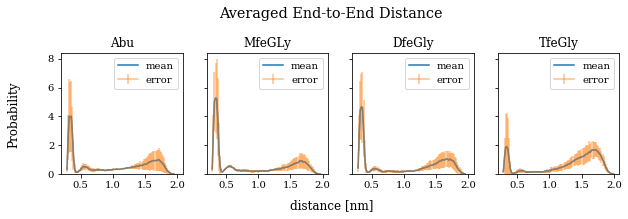

In [195]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (10,10))
fig.suptitle("Averaged End-to-End Distance", fontsize = "x-large", y = .65)


ax1.plot(x_abu, mean_abu, label = "mean")
ax2.plot(x_mfe, mean_mfe, label = "mean")
ax3.plot(x_dfe, mean_dfe, label = "mean")
ax4.plot(x_tfe, mean_tfe, label = "mean")

ax1.set_title("Abu")
ax2.set_title("MfeGLy")
ax3.set_title("DfeGly")
ax4.set_title("TfeGly")

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax4.set_box_aspect(1)

ax1.errorbar(x_abu, mean_abu, yerr = std_abu, label = "error", alpha=0.5)
ax2.errorbar(x_mfe, mean_mfe, yerr = std_mfe, label = "error", alpha=0.5)
ax3.errorbar(x_dfe, mean_dfe, yerr = std_dfe, label = "error", alpha=0.5)
ax4.errorbar(x_tfe, mean_tfe, yerr = std_tfe, label = "error", alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

fig.text(0.5, 0.37, "distance [nm]", ha = "center", fontsize = 12)
fig.text(0.05, 0.5, "Probability", va = "center", rotation ="vertical", fontsize = 12)
plt.xticks([0.5, 1, 1.5, 2])
plt.ylim(0)
    
plt.show()

**INTERPRETATION**

The end-to-end distance of each peptide was measured from the C-Atom at the glycine C-terminus to the N-Atom at amide of the valine N-Terminus. The results were plotted as histograms, weighing their probability density. The two peaks in the plot can be interpreted as $\alpha$ helix or closed state and $\beta$ sheet or open states. Generally, as the more substituted a hexapeptide is, the higher their probability density in the closed system is. Yet if it's being observed closer, there is a slight shift in their distance (tab. \ref{fig:tabe2e}) with decreasing distance from Abu to TfeGly. Probably this can be interpreted that the higher fluorine-subsituted hexapeptide do have stronger hydrogen bonds, so that the hexapeptides in both as $\alpha$ helices and $\beta$ sheets structure tend to bond tighter to itself.



# hydrogen bonds

In [200]:
hbond_abu_1 = md.wernet_nilsson(abu_1, exclude_water=True, periodic=False)
hbond_abu_2 = md.wernet_nilsson(abu_2, exclude_water=True, periodic=False)
hbond_abu_3 = md.wernet_nilsson(abu_3, exclude_water=True, periodic=False)
hbond_abu_4 = md.wernet_nilsson(abu_4, exclude_water=True, periodic=False)
hbond_abu_5 = md.wernet_nilsson(abu_5, exclude_water=True, periodic=False)

hbond_mfe_1 = md.wernet_nilsson(mfe_1, exclude_water=True, periodic=False)
hbond_mfe_2 = md.wernet_nilsson(mfe_2, exclude_water=True, periodic=False)
hbond_mfe_3 = md.wernet_nilsson(mfe_3, exclude_water=True, periodic=False)
hbond_mfe_4 = md.wernet_nilsson(mfe_4, exclude_water=True, periodic=False)
hbond_mfe_5 = md.wernet_nilsson(mfe_5, exclude_water=True, periodic=False)

hbond_dfe_1 = md.wernet_nilsson(dfe_1, exclude_water=True, periodic=False)
hbond_dfe_2 = md.wernet_nilsson(dfe_2, exclude_water=True, periodic=False)
hbond_dfe_3 = md.wernet_nilsson(dfe_3, exclude_water=True, periodic=False)
hbond_dfe_4 = md.wernet_nilsson(dfe_4, exclude_water=True, periodic=False)
hbond_dfe_5 = md.wernet_nilsson(dfe_5, exclude_water=True, periodic=False)

hbond_tfe_1 = md.wernet_nilsson(tfe_1, exclude_water=True, periodic=False)
hbond_tfe_2 = md.wernet_nilsson(tfe_2, exclude_water=True, periodic=False)
hbond_tfe_3 = md.wernet_nilsson(tfe_3, exclude_water=True, periodic=False)
hbond_tfe_4 = md.wernet_nilsson(tfe_4, exclude_water=True, periodic=False)
hbond_tfe_5 = md.wernet_nilsson(tfe_5, exclude_water=True, periodic=False)

In [201]:
hbond_abu = md.wernet_nilsson(traj_abu, exclude_water=True, periodic=False)
hbond_mfe = md.wernet_nilsson(traj_mfe, exclude_water=True, periodic=False)
hbond_dfe = md.wernet_nilsson(traj_dfe, exclude_water=True, periodic=False)
hbond_tfe = md.wernet_nilsson(traj_tfe, exclude_water=True, periodic=False)


In [82]:
n = 1

def hbond(x):
    "calculating hydrogen bonds in abu, in all timesteps"
    return md.wernet_nilsson(x, exclude_water = True, periodic = False)


In [ ]:
#def itn_abu(trajectory_abu_100, hbond_abu):
#    """Convert hydrogen bond index tuple to name"""
#    return f"{trajectory_abu_100.topology.atom(hbond_abu[0])}–{trajectory_abu_100.topology.atom(hbond_abu[2])}"

In [202]:
def hbond_name(traj, hbond_index):
    """Convert hydrogen bond index tuple to name"""
    return f"{traj.topology.atom(hbond_index[0])}–{traj.topology.atom(hbond_index[2])}"

In [205]:
from collections import defaultdict

In [206]:
# Count bonds
hb_frequency = defaultdict(int)

In [207]:
for frame in hbond_abu_1:
    for bond in frame:
        hb_frequency[tuple(bond)] += 1

In [208]:
def hbond_count(traj):
    for k, v in hb_frequency.items():
        print(f"{hbond_name(traj, k)}: {v}")
    print(f"{hbond_name(traj, k)}: {v}")
    print(k)
    print('')

In [210]:
hbond_count(traj_abu)

ALA5-N–GLY3-O: 174
GLY3-N–ALA5-O: 58
GLY3-N–CGLY7-OC2: 6
ALA5-N–NVAL2-O: 703
GLY3-N–CGLY7-OC1: 16
ALA5-N–ETG4-N: 2
ALA5-N–ETG4-N: 2
(38, 39, 25)



In [214]:
hbond_count(traj_mfe) == hbond_count(traj_dfe) == hbond_count(traj_tfe)

ALA5-N–GLY3-O: 174
GLY3-N–ALA5-O: 58
GLY3-N–CGLY7-OC2: 6
ALA5-N–NVAL2-O: 703
GLY3-N–CGLY7-OC1: 16
ALA5-N–E1G4-N: 2
ALA5-N–E1G4-N: 2
(38, 39, 25)

ALA5-N–GLY3-O: 174
GLY3-N–ALA5-O: 58
GLY3-N–CGLY7-OC2: 6
ALA5-N–NVAL2-O: 703
GLY3-N–CGLY7-OC1: 16
ALA5-N–E2G4-N: 2
ALA5-N–E2G4-N: 2
(38, 39, 25)

ALA5-N–GLY3-O: 174
GLY3-N–ALA5-O: 58
GLY3-N–CGLY7-OC2: 6
ALA5-N–NVAL2-O: 703
GLY3-N–CGLY7-OC1: 16
ALA5-N–E3G4-N: 2
ALA5-N–E3G4-N: 2
(38, 39, 25)



True

In [215]:
keys = list(map(lambda keys: hbond_name(tfe_1, keys), hb_frequency.keys()))

In [216]:
print(keys)

['ALA5-N–GLY3-O', 'GLY3-N–ALA5-O', 'GLY3-N–CGLY7-OC2', 'ALA5-N–NVAL2-O', 'GLY3-N–CGLY7-OC1', 'ALA5-N–E3G4-N']


In [217]:
def mer(dict1, dict2):
    return(dict1.update(dict2))

In [218]:
temp = {}
temp1 = {}

In [220]:
mer(temp, hb_frequency)

In [221]:
def h_perc(h_dict):
    total = len(tfe_3)
    for j in h_dict:
        h_dict[j] = (float)(h_dict[j])/total*100
    return h_dict

In [222]:
h_perc(temp)

{(38, 39, 24): 0.8699999999999999,
 (18, 19, 47): 0.29,
 (18, 19, 69): 0.03,
 (38, 39, 17): 3.515,
 (18, 19, 68): 0.08,
 (38, 39, 25): 0.01}

In [223]:
#rounding up the decimals
k = 5

#loop to iterate values
res = dict()
for key in temp:
    res[key] = round(temp[key], k)
    
print("rounded up:" + str(res) )

rounded up:{(38, 39, 24): 0.87, (18, 19, 47): 0.29, (18, 19, 69): 0.03, (38, 39, 17): 3.515, (18, 19, 68): 0.08, (38, 39, 25): 0.01}


In [225]:
#rounding up the decimals
k = 1

#loop to iterate values
percentage = dict()
for key in temp1:
    percentage[key] = round(temp1[key], k)
    
print("rounded up:" + str(percentage) )

rounded up:{(38, 39, 24): 174, (18, 19, 47): 58, (18, 19, 69): 6, (38, 39, 17): 703, (18, 19, 68): 16, (38, 39, 25): 2}


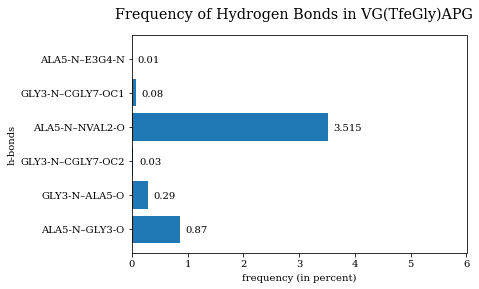

In [254]:
fig, ax = plt.subplots()
fig.suptitle("Frequency of Hydrogen Bonds in VG(TfeGly)APG", fontsize = "x-large")

ax.barh(keys, res.values())
for i, v in enumerate(res.values()):
    ax.text(v + 0.1, i - 0.1, str(v))



plt.xlim(0, 6)
plt.viridis()
plt.xlabel("frequency (in percent)")
plt.ylabel("h-bonds")
plt.show()


Although previous papers stated that an amino acid with at least one fluorine substitution will be more hydrophobic and waters are more tightly held at DfeGly and TfeGly\cite{2015} , this thesis proves otherwise. The non-fluorinated hexapeptide itself is hydrophobic \cite{2017} , but there is hardly any difference in the intramolecular hydrogen bonds between the any of the hexapeptides.